In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
import sys
from math import floor, ceil
from tensorflow import convert_to_tensor, Tensor, constant
import tensorflow as tf
import PIL
import PIL.ImageOps
from matplotlib import cm
from skimage.transform import hough_line, hough_line_peaks
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.path.isdir('/content/drive/MyDrive/Dataset_sketch/dataset')

True

In [4]:
imgpaths = {}
pth = '/content/drive/MyDrive/Dataset_sketch/dataset/png'
for d in os.listdir(pth):
    if not os.path.isdir(pth + '/' + d):
        continue
    for img in os.listdir(pth + '/' +d):
        path = '/content/drive/MyDrive/Dataset_sketch/dataset/png/'+d
        if d not in imgpaths:
            imgpaths[d] = []
        imgpaths[d].append(path + '/' + img)

In [5]:
list(imgpaths.keys())[:10]

['arm',
 'backpack',
 'airplane',
 'angel',
 'alarm clock',
 'axe',
 'ashtray',
 'armchair',
 'apple',
 'ant']

In [6]:
imgpaths['airplane'][:10]

['/content/drive/MyDrive/Dataset_sketch/dataset/png/airplane/4.png',
 '/content/drive/MyDrive/Dataset_sketch/dataset/png/airplane/16.png',
 '/content/drive/MyDrive/Dataset_sketch/dataset/png/airplane/21.png',
 '/content/drive/MyDrive/Dataset_sketch/dataset/png/airplane/22.png',
 '/content/drive/MyDrive/Dataset_sketch/dataset/png/airplane/46.png',
 '/content/drive/MyDrive/Dataset_sketch/dataset/png/airplane/27.png',
 '/content/drive/MyDrive/Dataset_sketch/dataset/png/airplane/37.png',
 '/content/drive/MyDrive/Dataset_sketch/dataset/png/airplane/44.png',
 '/content/drive/MyDrive/Dataset_sketch/dataset/png/airplane/43.png',
 '/content/drive/MyDrive/Dataset_sketch/dataset/png/airplane/40.png']

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, db_dir, batch_size, input_shape, num_classes=None, 
                 shuffle=True, dir_classes=False, grayscale=True):

        self.current_counter = 0
        self.label_dict = {}

        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        
        # load the data from the root directory
        self.data, self.labels = self.get_data(db_dir)
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()
        self.grayscale = grayscale


    def get_data(self, root_dir):
        """"
        Loads the paths to the images and their corresponding labels from the database directory
        """
        self.data = []
        self.labels = []

        labels_list = dict() # used to initialize label ids, for one-hot repr.
        
        imgpaths = {}
        path = root_dir
        pth = path
        
        labels_list_id = 0
        for d in os.listdir(pth)[:9]: # remove this
            
            # initialize ids for one-hot vector
            labels_list[d] = labels_list_id
            labels_list_id += 1
            #
            
            if not os.path.isdir(pth + '/' + d):
                continue
            for img in os.listdir(pth + '/' + d):
                path = '/content/drive/MyDrive/Dataset_sketch/dataset/png/'+ d
                if d not in imgpaths:
                    imgpaths[d] = []
                imgpaths[d].append(path + '/' + img)
                
        for i in imgpaths.keys():
            for j in imgpaths[i]:
                self.data.append(j)
                self.labels.append(tf.one_hot(labels_list[i], depth=len(os.listdir(pth)[:9])))

        return self.data, self.labels

    def __len__(self):
        """
        Returns the number of batches per epoch: the total size of the dataset divided by the batch size
        """
        return int(np.floor(len(self.data) / self.batch_size))
        # TODO your code  here (size of dataset divided by the batch size)
        return 0
    
    def vec_to_tensor(self, v):
      return constant(v)
    
    """
        Preprocesses before outputting to .fit()
        This can mean: reshape, channel count check, mean subtraction and std. dev division.
    """
    def batch_to_train(self, batch_x, batch_y):
        x_train = [self.vec_to_tensor(x) for x in batch_x]
        y_train = [self.vec_to_tensor(x) for x in batch_y]

        #print(self.input_shape)
        x_train = [cv2.resize(np.array(i), (self.input_shape[0], self.input_shape[1])) for i in x_train]
        x_train2 = []
        y_train2 = []

        for i in range(len(x_train)):
          if (x_train[i].shape[0] == self.input_shape[0] and x_train[i].shape[1] == self.input_shape[1]):
            x_train2.append(x_train[i])
            y_train2.append([y_train[i].numpy(), 0 if y_train[i].numpy() == 1 else 1])

        y_test = y_train2[:floor(1/5 * self.batch_size)]
        x_test = x_train2[:floor(1/5 * self.batch_size)]

        x_train = x_train2[ceil(1/5 * self.batch_size + 1):]
        y_train = y_train2[ceil(1/5 * self.batch_size + 1):]

        
        
        x_train = np.array(x_train)
        y_train = np.array(y_train)

        
        x_test = np.array(x_test)
        y_test = np.array(y_test)
        
        print(x_train.shape)
        
        return x_train, y_train

    def __getitem__(self, index):
        """"
        Generates a batch of data
        Note: computation intensivity
        """

        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        
        batch_x = [] # TODO load the image(s) from batch_indices
        batch_y = [] # TODO load the corresponding labels of the images you loaded

        for i in batch_indices:
          ci = self.data[i]
          cl = self.labels[i]
            
          cd = Image.open(ci) #.convert('L')
          inverted_image = PIL.ImageOps.invert(cd)
          cd = np.array(inverted_image)

          if self.grayscale:
            cd = cv2.resize(cd, (self.input_shape[0], self.input_shape[1]))
          else:
            cd = cv2.resize(cd, (self.input_shape[0], self.input_shape[1]))
            cdc = cd.copy()
            cd = np.reshape(cd, (self.input_shape[0], self.input_shape[1], 1))
            cd = np.append(cd, cd, axis=2)
            cd = np.append(cd, np.reshape(cdc, (self.input_shape[0], self.input_shape[1], 1)), axis=2)
            
          batch_x.append(cd)
          batch_y.append(cl)
        
        
        return np.array(batch_x), batch_y

    def on_epoch_end(self):
        """"
        Called at the end of each epoch
        """
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [8]:
class DataVisualizer:
    @staticmethod
    def plot_batch(vec, count=1):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=[16, 16], dpi=(200))
        for i in range(len(axes)):
            axes[i].imshow(vec[i], cmap=plt.get_cmap('gray'), vmin=0, vmax=255., interpolation="none")
        plt.show()

In [9]:
d = DataGenerator(
    db_dir='/content/drive/MyDrive/Dataset_sketch/dataset/png',
    batch_size=12,
    input_shape=(160, 160),
    dir_classes=True
)

In [10]:
batch = d[0]

In [11]:
one_img = batch[0][0]

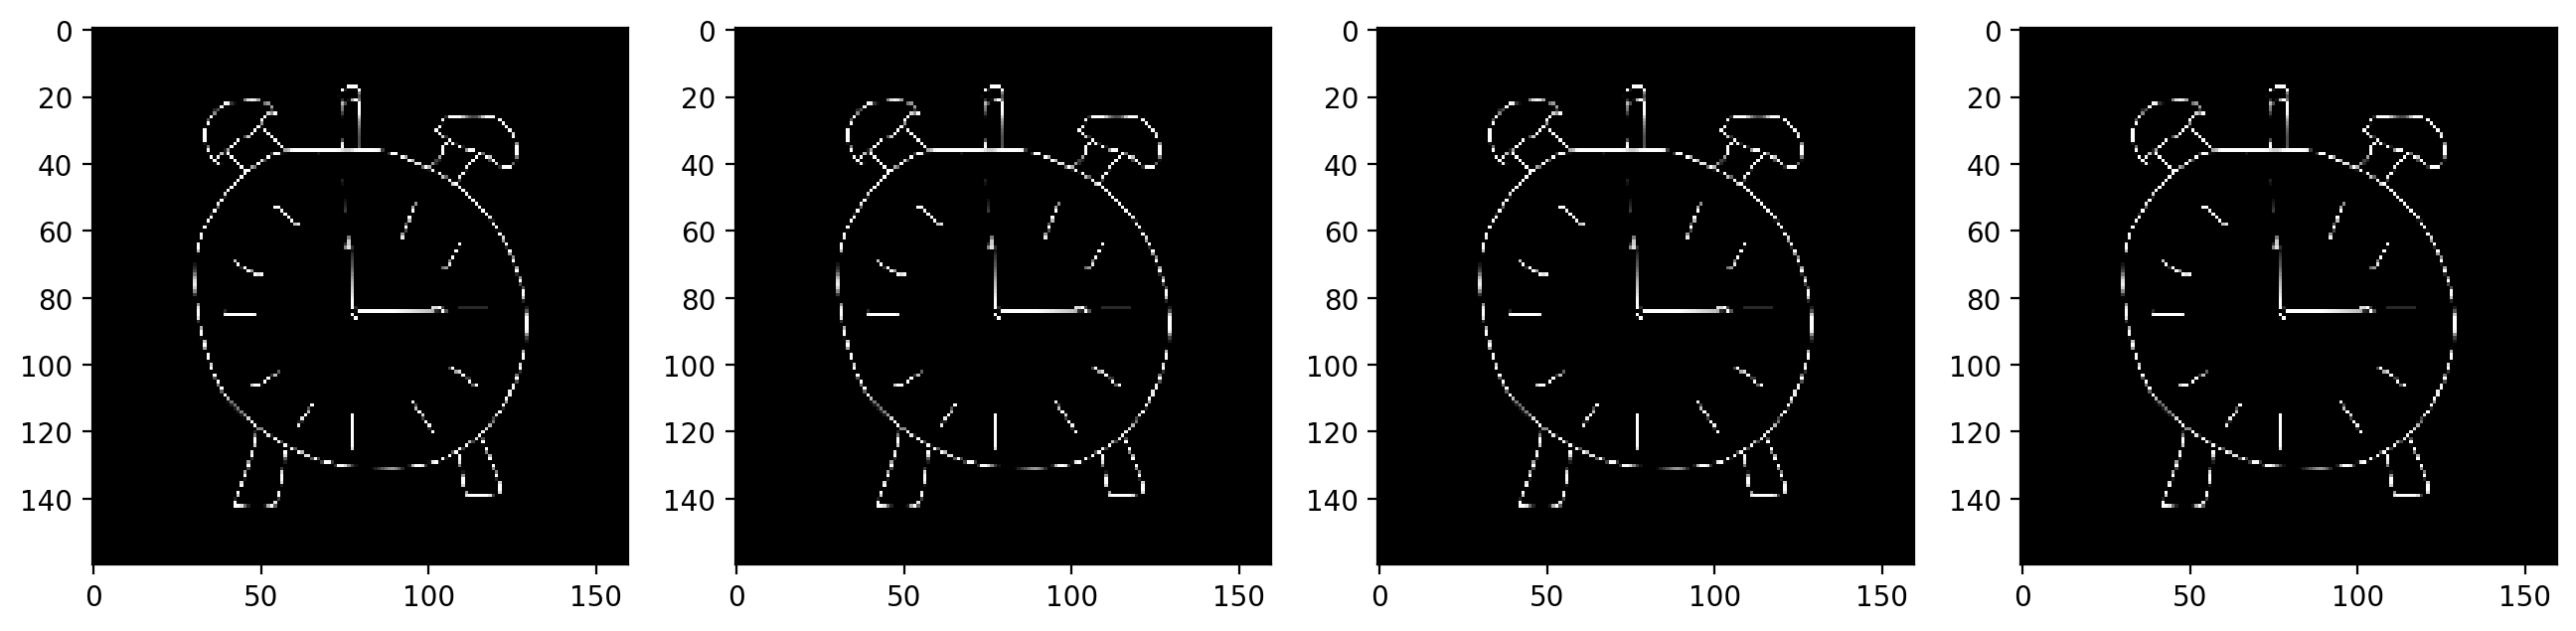

In [12]:
DataVisualizer.plot_batch([one_img, one_img, one_img, one_img], count=1)

In [13]:
d = DataGenerator(
    db_dir='/content/drive/MyDrive/Dataset_sketch/dataset/png',
    batch_size=1500,
    input_shape=(160, 160),
    dir_classes=True
)

In [14]:
vx = d[0]

In [15]:
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
def transform_img_vec(X):
    newVec = []
    for img in X:
        h, theta, d = hough_line(img, theta=tested_angles)
        newVec.append(h)
    newVec = np.array(newVec)
    return newVec

In [16]:
X_train = vx[0]
y_train = np.array(vx[1])
X_test = X_train[601:]
y_test = y_train[601:]
X_train = X_train[:600]
y_train = y_train[:600]

In [17]:
X_train = transform_img_vec(X_train)

In [18]:
X_test = transform_img_vec(X_test)

In [19]:
X_train.shape

(600, 454, 360)

In [20]:
X_train[0].shape

(454, 360)

In [21]:
X_train[1].shape

(454, 360)

In [22]:
vgg16 = tf.keras.applications.vgg16.VGG16(
    include_top=True,
    input_shape=(454, 360, 1),
    classes=9,
    weights=None
)

In [38]:
vgg16.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [24]:
history = vgg16.fit(
    X_train,
    y_train,
    batch_size=2,
    epochs=8,
)

Epoch 1/8
300/300 [==============================] - 172s 526ms/step - loss: 1.6718 - accuracy: 0.3867
Epoch 2/8
300/300 [==============================] - 158s 527ms/step - loss: 0.9111 - accuracy: 0.6933
Epoch 3/8
300/300 [==============================] - 158s 526ms/step - loss: 0.6843 - accuracy: 0.7583
Epoch 4/8
300/300 [==============================] - 158s 526ms/step - loss: 0.4689 - accuracy: 0.8467
Epoch 5/8
300/300 [==============================] - 158s 526ms/step - loss: 0.3200 - accuracy: 0.8967
Epoch 6/8
300/300 [==============================] - 158s 526ms/step - loss: 0.2055 - accuracy: 0.9383
Epoch 7/8
300/300 [==============================] - 158s 525ms/step - loss: 0.2347 - accuracy: 0.9283
Epoch 8/8
300/300 [==============================] - 158s 525ms/step - loss: 0.1121 - accuracy: 0.9700


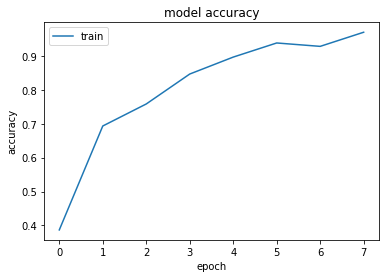

In [27]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
history

In [39]:
eval = vgg16.evaluate(X_test, y_test)

2/2 [==============================] - 2s 410ms/step - loss: 0.8547 - accuracy: 0.7949 - precision_1: 0.7949 - recall: 0.7949


In [40]:
eval

[0.8547302484512329,
 0.7948718070983887,
 0.7948718070983887,
 0.7948718070983887]

In [25]:
vgg16.save_weights('/content/drive/MyDrive/Dataset_sketch/weights')